In [1]:
# TO USE: 
#    1. Upload your input and output wav files to the current directory in Colab
#    2. Edit the USER INPUTS section to point to your wav files, and choose a
#         model name, and number of epochs for training. If you experience 
#         crashing due to low RAM, reduce the "input_size" parameter, or increase
#         the "split_data" parameter.
#    3. Run each section of code. The trained models and output wav files will be 
#         added to the "models" directory.
#
#     Note: Tested on CPU and GPU runtimes.

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.activations import tanh, elu, relu
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

import os
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import json



In [2]:
# EDIT THIS SECTION FOR USER INPUTS
#
name = 'junk_stereo'
in_file = 'SmartAmpProSample.wav'
#out_file = 'lead_gran_halfG.wav'
#in_file = 'ts9_test1_in_FP32.wav'
#out_file = 'ts9_test1_out_FP32.wav'
epochs = 1
split_data=6 # **Increase this to reduce RAM usage **

train_mode = 0     # 0 = speed training, 
                   # 1 = accuracy training 
                   # 2 = extended training

input_size = 180  # !!!IMPORTANT !!!: The input_size is set at 150 for Colab notebook. 
                 #                     A higher setting may result in crashing due to
                 #                     memory limitation of 8GB for the free version
                 #                     of Colab. This setting limits the accuracy of
                 #                     the training, especially for complex guitar signals
                 #                     such as high distortion.
                 #                 
                 # !!!IMPORTANT!!!: You will most likely need to cycle the runtime to 
                 #                   free up RAM between training sessions.
                 #
                 # Increase the "split_data" parameter to reduce the RAM used and
                 #    still allow for a higher "input_size" setting.     
                 #
                 # Future dev note: Using a custom dataloader may be a good
                 #                     workaround for this limitation, at the cost
                 #                     of slower training.

if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit


A model with the same name already exists. Please choose a new name.


In [3]:

def pre_emphasis_filter(x, coeff=0.95):
    return tf.concat([x, x - coeff * x], 1)
    
def error_to_signal(y_true, y_pred): 
    """
    Error to signal ratio with pre-emphasis filter:
    """
    y_true, y_pred = pre_emphasis_filter(y_true), pre_emphasis_filter(y_pred)
    return K.sum(tf.pow(y_true - y_pred, 2), axis=0) / K.sum(tf.pow(y_true, 2), axis=0) + 1e-10
    
def save_wav(name, data):
    wavfile.write(name, 44100, data.flatten().astype(np.float32))

def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm


'''This is a similar Tensorflow/Keras implementation of the LSTM model from the paper:
    "Real-Time Guitar Amplifier Emulation with Deep Learning"
    https://www.mdpi.com/2076-3417/10/3/766/htm

    Uses a stack of two 1-D Convolutional layers, followed by LSTM, followed by 
    a Dense (fully connected) layer. Three preset training modes are available, 
    with further customization by editing the code. A Sequential tf.keras model 
    is implemented here.

    Note: RAM may be a limiting factor for the parameter "input_size". The wav data
      is preprocessed and stored in RAM, which improves training speed but quickly runs out
      if using a large number for "input_size".  Reduce this if you are experiencing
      RAM issues. 
    
    --training_mode=0   Speed training (default)
    --training_mode=1   Accuracy training
    --training_mode=2   Extended training (set max_epochs as desired, for example 50+)
'''

batch_size = 4096 
test_size = 0.2

if train_mode == 0:         # Speed Training
    learning_rate = 0.01 
    conv1d_strides = 12
    conv1d_1_strides = 12   
    conv1d_filters = 4
    hidden_units = 24
elif train_mode == 1:       # Accuracy Training (~10x longer than Speed Training)
    learning_rate = 0.01 
    conv1d_strides = 4
    conv1d_filters = 36
    hidden_units= 64
else:                       # Extended Training (~60x longer than Accuracy Training)
    learning_rate = 0.0005 
    conv1d_strides = 3
    conv1d_filters = 36
    hidden_units= 96
    conv1d_KS = conv1d_strides 
    conv1d_1_KS = conv1d_1_strides

conv1d_KS = conv1d_strides 
conv1d_1_KS = conv1d_1_strides

# Create Sequential Model ###########################################
clear_session()
model = Sequential()
model.add(Conv1D(conv1d_filters, conv1d_KS, strides=conv1d_strides, activation=None, padding='same',input_shape=(input_size,1)))
model.add(Conv1D(conv1d_filters, conv1d_1_KS, strides=conv1d_1_strides, activation=None, padding='same'))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation=None))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=error_to_signal, metrics=[error_to_signal])
print(model.summary())

# Load and Preprocess Data ###########################################
#in_rate, in_data = wavfile.read(in_file)
#out_rate, out_data = wavfile.read(out_file)
in_rate, stereo_data = wavfile.read(in_file)

in_data = stereo_data.T[0]
out_data = stereo_data.T[1]

X_all = in_data.astype(np.float32).flatten()  
X_all = normalize(X_all).reshape(len(X_all),1)   
y_all = out_data.astype(np.float32).flatten() 
y_all = normalize(y_all).reshape(len(y_all),1)   

# If splitting the data for training, do this part
if split_data > 1:
    num_split = len(X_all) // split_data
    X = X_all[0:num_split*split_data]
    y = y_all[0:num_split*split_data]
    X_data = np.split(X, split_data)
    y_data = np.split(y, split_data)

    # Perform training on each split dataset
    for i in range(len(X_data)):
        print("\nTraining on split data " + str(i+1) + "/" +str(len(X_data)))
        X_split = X_data[i]
        y_split = y_data[i]

        y_ordered = y_split[input_size-1:] 

        indices = np.arange(input_size) + np.arange(len(X_split)-input_size+1)[:,np.newaxis] 
        X_ordered = tf.gather(X_split,indices) 

        shuffled_indices = np.random.permutation(len(X_ordered)) 
        X_random = tf.gather(X_ordered,shuffled_indices)
        y_random = tf.gather(y_ordered, shuffled_indices)

        # Train Model ###################################################
        model.fit(X_random,y_random, epochs=epochs, batch_size=batch_size, validation_split=0.2)  


    model.save('models/'+name+'/'+name+'.h5')

# If training on the full set of input data in one run, do this part
else:
    y_ordered = y_all[input_size-1:] 

    indices = np.arange(input_size) + np.arange(len(X_all)-input_size+1)[:,np.newaxis] 
    X_ordered = tf.gather(X_all,indices) 

    shuffled_indices = np.random.permutation(len(X_ordered)) 
    X_random = tf.gather(X_ordered,shuffled_indices)
    y_random = tf.gather(y_ordered, shuffled_indices)

    # Train Model ###################################################
    model.fit(X_random,y_random, epochs=epochs, batch_size=batch_size, validation_split=test_size)    

    model.save('models/'+name+'/'+name+'.h5')

# Run Prediction #################################################
#print("Running prediction..")

# Get the last 20% of the wav data to run prediction and plot results
y_the_rest, y_last_part = np.split(y_all, [int(len(y_all)*.8)])
x_the_rest, x_last_part = np.split(X_all, [int(len(X_all)*.8)])
y_test = y_last_part[input_size-1:] 
indices = np.arange(input_size) + np.arange(len(x_last_part)-input_size+1)[:,np.newaxis] 
X_test = tf.gather(x_last_part,indices) 

prediction = model.predict(X_test, batch_size=batch_size)

save_wav('models/'+name+'/y_pred.wav', prediction)
save_wav('models/'+name+'/x_test.wav', x_last_part)
save_wav('models/'+name+'/y_test.wav', y_test)

# Add additional data to the saved model (like input_size)
filename = 'models/'+name+'/'+name+'.h5'
f = h5py.File(filename, 'a')
grp = f.create_group("info")
dset = grp.create_dataset("input_size", (1,), dtype='int16')
dset[0] = input_size
dset2 = grp.create_dataset("conv1d_stride", (1,), dtype='int16')
dset3 = grp.create_dataset("conv1d_1_stride", (1,), dtype='int16')
dset[0] = input_size
dset2[0] = conv1d_strides
dset3[0] = conv1d_1_strides

f.close()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15, 4)             52        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 4)              196       
_________________________________________________________________
lstm (LSTM)                  (None, 24)                2784      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 3,057
Trainable params: 3,057
Non-trainable params: 0
_________________________________________________________________
None

Training on split data 1/6
282/282 [==============================] - 6s 9ms/step - loss: 0.1801 - error_to_signal: 0.1801 - val_loss: 6.1945e-04 - val_error_to_signal: 6.1955e-04

Training on split data 2/6
282/282 [=============================

In [4]:
  # Generate json model ################################
  filename = 'models/'+name+'/'+ name +'.h5'
  json_filename = 'models/'+name+'/'+ name
  f = h5py.File(filename, 'r')
  # List all groups
  #print("Keys: %s" % f.keys())
  # List all layers
  #print("Layers: %s" % f[list(f.keys())[0]].keys())

  # Load the model data
  data = {}
  for layer in f["model_weights"].keys():
      if layer not in data.keys():
          data[layer] = {}
      for item in f["model_weights"][layer][layer]:
          if item not in data[layer].keys():
              data[layer][item] = {}
              try:
                  data[layer][item] = f["model_weights"][layer][layer][item][:].tolist()
              except:
                  data[layer]["kernel:0"] = f["model_weights"][layer][layer][item]["kernel:0"][:].tolist()
                  data[layer]["bias:0"] = f["model_weights"][layer][layer][item]["bias:0"][:].tolist()
          else:
              try:
                  data[layer][item] = f["model_weights"][layer][layer][item][:].tolist()
              except:
                  data[layer]["kernel:0"] = f["model_weights"][layer][layer][item]["kernel:0"][:].tolist()
                  data[layer]["bias:0"] = f["model_weights"][layer][layer][item]["bias:0"][:].tolist()

  input_size = f["info"]["input_size"][0]
  conv1d_strides = f["info"]["conv1d_stride"][0]
  conv1d_1_strides = f["info"]["conv1d_1_stride"][0]
  data['input_size'] = int(input_size)
  print("input_size: ",input_size)
  data['conv1d_stride'] = int(conv1d_strides)
  data['conv1d_1_stride'] = int(conv1d_1_strides)
  f.close()

  with open(json_filename + ".json", 'w') as outfile:
      json.dump(data, outfile)
  print("SmartAmpPro model generated: ", json_filename + ".json")

input_size:  180
SmartAmpPro model generated:  models/junk_stereo/junk_stereo.json


Plotting results..
Error to signal (with pre-emphasis filter):  3.838366e-05
Error to signal (no pre-emphasis filter):  3.838365e-05


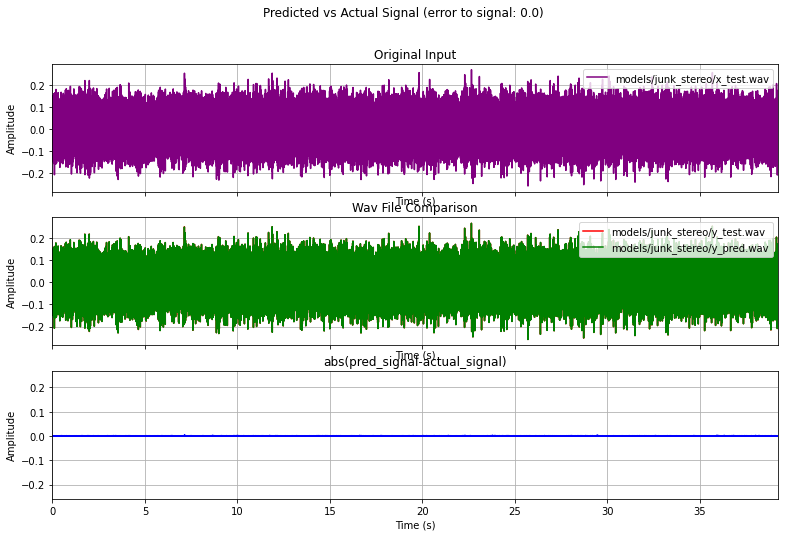

In [5]:
        print("Plotting results..")
        import plot

        plot.analyze_pred_vs_actual({   'output_wav':'models/'+name+'/y_test.wav',
                                            'pred_wav':'models/'+name+'/y_pred.wav', 
                                            'input_wav':'models/'+name+'/x_test.wav',
                                            'model_name':name,
                                            'show_plots':1,
                                            'path':'models/'+name
                                        })